<a href="https://colab.research.google.com/github/lacls/Aspect-Based-Sentiment-Analysis/blob/master/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Library installation*

In [1]:
!pip install underthesea
!pip install pyvi
!pip install torch==1.4.0
!pip install python-rdrsegmenter

import numpy as np
from numpy import random
import random as rn
random.seed(12345)
import tensorflow as tf
np.random.seed(12345)
rn.seed(12345)
from underthesea import word_tokenize,  pos_tag
import os, pickle, re, keras, sklearn, string
from pyvi import ViTokenizer, ViPosTagger
from transformers import AutoModel, AutoTokenizer
from keras.preprocessing.sequence import pad_sequences
from scipy import spatial
import pandas as pd
import random
from transformers import pipeline, AutoModelWithLMHead, AutoTokenizer
import pandas as pd
from python_rdrsegmenter import load_segmenter
rdrsegmenter = load_segmenter()

#_________
## Cleaan doc
def normalText(sent):
    sent = str(sent).replace('_',' ').replace('/',' trên ')
    sent = re.sub('-{2,}','',sent)
    sent = re.sub('\\s+',' ', sent)
    patPrice = r'([0-9]+k?(\s?-\s?)[0-9]+\s?(k|K))|([0-9]+(.|,)?[0-9]+\s?(triệu|ngàn|trăm|k|K|))|([0-9]+(.[0-9]+)?Ä‘)|([0-9]+k)'
    patHagTag = r'#\s?[aăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ]+'
    patURL = r"(?:http://|www.)[^\"]+"
    sent = re.sub(patURL,'website',sent)
    sent = re.sub(patHagTag,' hagtag ',sent)
    sent = re.sub(patPrice, ' giá_tiền ', sent)
    sent = re.sub('\.+','.',sent)
    sent = re.sub('(hagtag\\s+)+',' hagtag ',sent)
    sent = re.sub('\\s+',' ',sent)
    return sent


def normalize_elonge_word(sent):
    s_new = ''
    for word in sent.split(' '):
        word_new = ''
        for char in word.strip():
            if char != word_new[-1]:
                word_new += char
    s_new += word_new.strip() + ' '
    return s_new

def tokenizer(text):
      token = word_tokenize(text,format="text")
      token = token.replace('giá tiền','giá_tiền').replace('Giá tiền','Giá_tiền')
      return token

def deleteIcon(text):
    text = text.lower()
    s = ''
    pattern = r"[a-zA-ZaăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ,._]"
    
    for char in text:
        if char !=' ':
            if len(re.findall(pattern, char)) != 0:
                s+=char
            elif char == '_':
                s+=char
        else:
            s+=char
    s = re.sub('\\s+',' ',s)
    return s.strip()

def normalize_elonge_word(sent):
    s_new = ''
    for word in sent.split(' '):
        word_new = ' '
        for char in word.strip():
            if char != word_new[-1]:
                word_new += char
        s_new += word_new.strip() + ' '
    return s_new.strip()  

def clean_doc(doc,set_work=False):
    for punc in string.punctuation:
        doc = doc.replace(punc,' '+ punc + ' ')
    doc = normalText(doc)
    doc = deleteIcon(doc)
    if set_work:
      doc = rdrsegmenter.tokenize(doc)
      doc = doc.translate(doc.maketrans('', '', string.punctuation.replace("_","")))

    # Lowercase
    doc = doc.lower()
    # Removing multiple whitespaces
    doc = re.sub(r"\?", " \? ", doc)
    # Remove numbers
    doc = re.sub(r"[0-9]+", " num ", doc)
    # Split in tokens
    # Remove punctuation
    for punc in string.punctuation:
      if punc not in "_":
          doc = doc.replace(punc,' ')
    doc = re.sub('\\s+',' ',doc)
    doc = normalize_elonge_word(doc)
    return doc

# Data Configuration

## Read file

In [ ]:
# Install colab_ssh on google colab
!pip install colab_ssh --upgrade

from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password="str")

# Optional: if you want to clone a github repository
#init_git_cloudflared(githubRepositoryUrl)

## Library Install

## AVIVN

> Notice: positive is 0, negative is 1, according the webpage

In [ ]:
idx_=[]
text=[]
label=[]
import collections
##AVIVN

with open("/content/drive/MyDrive/Thesis/Data/SA_demo/train.txt","r") as f:
    bla=f.readlines()

store_text=""
idx_=[]
text=[]
label=[]
for value in bla:
  value=value.replace("\n","")
  if value:
    if "train" in value:
      if store_text:
        text.append(store_text)
        store_text=""
        if len(text)!=len(label):
          print(value)
          break
      idx_.append(value)
    elif collections.Counter(value)['"']==2:
      text.append(value.replace('"',""))
    elif value in ["0","1","2"]:
      label.append(value)
    else:
      value=value.replace('"',"")
      store_text+=f"{value} "

data_csv=pd.DataFrame(data={'text':text,'label':label})
data_csv.to_csv("/content/drive/MyDrive/Thesis/Data/aivivn_train.csv",index=False)

In [ ]:
import collections
##AVIVN

with open("/content/drive/MyDrive/Thesis/Data/SA_demo/test.txt","r") as f:
    bla=f.readlines()

store_text=""
idx_=[]
text=[]
label=[]
for value in bla:
  value=value.replace("\n","")
  if value:
    if "test_" in value:
      if store_text:
        text.append(store_text)
        store_text=""
        if len(text)!=len(idx_):
          break
      idx_.append(value)
    elif collections.Counter(value)['"']==2:
      text.append(value.replace('"',""))
    # elif value in ["0","1","2"]:
    #     label.append(value)
    else:
      value=value.replace('"',"")
      store_text+=f"{value} "

data_csv=pd.DataFrame(data={'idx_':idx_,'text':text})
data_csv.to_csv("/content/drive/MyDrive/Thesis/Data/aivivn_test.csv",index=False)

## KSE

> Notice: Neutral is labeled 2, Negative is 0 and Positive is 1

In [ ]:
idx_=[]
text=[]
label=[]
import collections
import os
sentiment_Value=0
for value in os.listdir('/content/drive/MyDrive/[1] Thesis/Data/KSE/train/'):
  with open(f"/content/drive/MyDrive/[1] Thesis/Data/KSE/train/{value}","r") as f:
      data=f.readlines()
      if "_0" in value:
        sentiment_Value=0
      elif "_1" in value:
        sentiment_Value=1
      else:
        sentiment_Value=2
      for h in data:
        text.append(h)
        label.append(sentiment_Value)

data_csv=pd.DataFrame(data={'text':text,'label':label})
data_shuffle=data_csv.sample(frac=1).reset_index(drop=True)
data_shuffle.to_csv("/content/drive/MyDrive/[1] Thesis/Data/kse_train.csv",index=False)     
  
idx_=[]
text=[]
label=[]
import collections
import os
sentiment_Value=0
for value in os.listdir('/content/drive/MyDrive/[1] Thesis/Data/KSE/test/'):
  with open(f"/content/drive/MyDrive/[1] Thesis/Data/KSE/test/{value}","r") as f:
      data=f.readlines()
      if "_0" in value:
        sentiment_Value=0
      elif "_1" in value:
        sentiment_Value=1
      else:
        sentiment_Value=2
      for h in data:
        text.append(h)
        label.append(sentiment_Value)
  
data_csv=pd.DataFrame(data={'text':text,'label':label})
data_shuffle=data_csv.sample(frac=1).reset_index(drop=True)
data_shuffle.to_csv("/content/drive/MyDrive/[1] Thesis/Data/kse_test.csv",index=False)     
    

## UIT-VSFC

In [ ]:
import pandas as pd

idx_=[]
text=[]
label=[]
import collections
import os
with open(f"/content/drive/MyDrive/Thesis/Data/UIT-VSFC/train/sents.txt","r") as f:
    text=f.read().splitlines()

with open(f"/content/drive/MyDrive/Thesis/Data/UIT-VSFC/train/sentiments.txt","r") as f:
    label=f.read().splitlines()

data_csv=pd.DataFrame(data={'text':text,'label':label})
data_csv.to_csv("/content/drive/MyDrive/Thesis/Data/uit_TOPICS_vsfc_train.csv",index=False)


with open(f"/content/drive/MyDrive/Thesis/Data/UIT-VSFC/dev/sents.txt","r") as f:
    text=f.read().splitlines()

with open(f"/content/drive/MyDrive/Thesis/Data/UIT-VSFC/dev/sentiments.txt","r") as f:
    label=f.read().splitlines()

data_csv=pd.DataFrame(data={'text':text,'label':label})
data_csv.to_csv("/content/drive/MyDrive/Thesis/Data/uit_TOPICS_vsfc_dev.csv",index=False)

with open(f"/content/drive/MyDrive/Thesis/Data/UIT-VSFC/test/sents.txt","r") as f:
    text=f.read().splitlines()

with open(f"/content/drive/MyDrive/Thesis/Data/UIT-VSFC/test/sentiments.txt","r") as f:
    label=f.read().splitlines()

data_csv=pd.DataFrame(data={'text':text,'label':label})
data_csv.to_csv("/content/drive/MyDrive/Thesis/Data/uit_TOPICS_vsfc_test.csv",index=False)

In [ ]:
data_csv=pd.read_csv("/content/drive/MyDrive/Thesis/Data/uit_TOPICS_vsfc_dev.csv")
data_csv

,text,label
0,giáo trình chưa cụ thể .,0
1,giảng buồn ngủ .,0
2,"giáo viên vui tính , tận tâm .",2
3,"giảng viên nên giao bài tập nhiều hơn , chia n...",0
4,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",0
...,...,...
1578,hướng dẫn lab mơ hồ .,0
1579,thầy cho chúng em những bài tập mang tính thực...,2
1580,thầy không dạy nhiều chủ yếu cho sinh viên tự ...,0
1581,em muốn đổi tên môn học vì tên môn là lập trìn...,0


## VLSP

In [ ]:
import pandas as pd
import numpy as np

text=[]
sentiment=[]

with open("/content/drive/MyDrive/Thesis/Data/VLSP 2016/SA2016-training_data/SA-training_positive.txt","r") as f:
    bla=f.read().splitlines() 
    k=0
    for h in bla:
      if h!="":
        text.append(h)
        k+=1
    for _ in range(k):
      sentiment.append(1)

In [ ]:

with open("/content/drive/MyDrive/Thesis/Data/VLSP 2016/SA2016-training_data/SA-training_neutral.txt","r") as f:
    bla=f.read().splitlines() 
    k=0
    for h in bla:
      if h!="":
        text.append(h)
        k+=1
    for _ in range(k):
      sentiment.append(-1)
with open("/content/drive/MyDrive/Thesis/Data/VLSP 2016/SA2016-training_data/SA-training_negative.txt","r") as f:
    bla=f.read().splitlines() 
    k=0
    for h in bla:
      if h!="":
        text.append(h)
        k+=1
    for _ in range(k):
      sentiment.append(0)



data_csv=pd.DataFrame(data={'text':text,'sentiment':sentiment})
data_shuffle=data_csv.sample(frac=1).reset_index(drop=True)

data_shuffle.to_csv("/content/drive/MyDrive/Thesis/Data/vlsp_train.csv",index=False)

In [ ]:
import pandas as pd
text=[]
sentiment=[]
with open("/content/drive/MyDrive/Thesis/Data/VLSP 2016/SA2016-TestData-Ans/test_raw_ANS.txt","r") as f:
    bla=f.read().splitlines() 
    for index, value in enumerate(bla):
      if index%2==0:
        text.append(value)
      else:
        if value=="POS":
          sentiment.append(1)
        elif value=="NEU":
          sentiment.append(-1)
        else:
          sentiment.append(0)

data_csv=pd.DataFrame(data={'text':text,'sentiment':sentiment})
data_shuffle=data_csv.sample(frac=1).reset_index(drop=True)
data_shuffle.to_csv("/content/drive/MyDrive/Thesis/Data/vlsp_test.csv",index=False)

## HOTEL

In [ ]:
import re
import pandas as pd
sentiment=[]
text=[]
datContent = [i for i in open("/content/drive/MyDrive/[1] Thesis/Data/data1Wordalltrain.dat").readlines()]
for h in datContent:
  string=""
  for value in h.split(" "):
    if "NEGA" in value:
      sentiment.append(-1)
    elif "POS" in value:
      sentiment.append(1)
    elif "NEU" in value:
      sentiment.append(0)
    else:
      value_=re.sub("[\/].*$","",value)
      string=string.join(f'{value_} ')
  text.append(string)
  if len(sentiment)!=len(text):
    break
    print(string)

data_csv=pd.DataFrame(data={'text':text,'sentiment':sentiment})
data_shuffle=data_csv.sample(frac=1).reset_index(drop=True)

data_shuffle.to_csv("/content/drive/MyDrive/[1] Thesis/Data/hotel.csv",index=False)

In [ ]:
msk = np.random.rand(len(data_shuffle)) <= 0.7
train = data_shuffle[msk]
test = data_shuffle[~msk]

# Data Augmentation

### **Word_2Vec replacement**
- For each word in a tweet, we query the exter- nal embeddings, and replace them with their knn words to create a new training instance. For ex- ample, consider the tweet “Being late is terrible” with the punctuality label, after searching for knn words for each token, we create a new training in- stance: “Be behind are bad” with the same label

- IMPORTANT, This can lead to out-of-context and unnat- urally complex replacements 

#### *Baomoi*

In [ ]:
print(ViPosTagger.postagging(clean_doc(text[0],True)))
print(pos_tag(clean_doc(text[0])))
# https://pypi.org/project/pyvi/
#model_bao_moi.similar_by_word("son",10)

(['dung', 'dc', 'sp', 'tot', 'cam', 'on_shop', 'đóng_gói', 'sản_phẩm', 'rất', 'đẹp', 'và', 'chắc_chắn', 'chất_lượng', 'sản_phẩm', 'tuyệt_vời'], ['N', 'V', 'N', 'V', 'N', 'N', 'N', 'N', 'R', 'A', 'C', 'A', 'N', 'N', 'A'])
[('dung', 'N'), ('dc', 'V'), ('sp', 'N'), ('tot', 'V'), ('cam', 'N'), ('on shop', 'N'), ('đóng gói', 'V'), ('sản phẩm', 'N'), ('rất', 'R'), ('đẹp', 'A'), ('và', 'C'), ('chắc chắn', 'A'), ('chất lượng', 'N'), ('sản phẩm', 'N'), ('tuyệt vời', 'A')]


In [ ]:
model_bao_moi.similar_by_word("ảnh",10)

[('hình', 0.7319726943969727),
 ('hình_hài_hước', 0.6114365458488464),
 ('hình_ảnh', 0.5983822345733643),
 ('screenshot', 0.5368694067001343),
 ('Ảnh_cực_Đã', 0.5335326194763184),
 ('bộ_ảnh', 0.5332967638969421),
 ('tiệc_cực_vui', 0.5284527540206909),
 ('loobook', 0.5211629867553711),
 ('choẹt', 0.5155001282691956),
 ('hình_như_thế', 0.5113717317581177)]

In [ ]:
import gensim
model_bao_moi = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/NLP@Research/Aspect/Embedding/baomoi.bin', binary=True)


#### *fastText*

In [ ]:
from gensim.models.wrappers import FastText
model_ftext = FastText.load_fasttext_format('/content/drive/MyDrive/NLP@Research/Aspect/Embedding/cc.vi.300.bin')
model_ftext.similar_by_word("ai_vậy",10)

### **Bert-base**

- Transformer models such as BERT, ROBERTA, and ALBERT have been trained on a large amount of text using a pretext task called “Masked Language Modeling” where the model has to predict masked words based on the context.

In [ ]:
from transformers import pipeline, AutoModelWithLMHead, AutoTokenizer
from tqdm import tqdm
tokenizer_ = AutoTokenizer.from_pretrained("vinai/phobert-large")
model_ = AutoModelWithLMHead.from_pretrained("vinai/phobert-large").to('cuda').half() 
nlp = pipeline("fill-mask", model=model_,tokenizer=tokenizer_,topk=2)
nlp('dung dc sp <mask> cam on shop đóng_gói sản_phẩm rất đẹp và chắc_chắn chất_lượng sản_phẩm tuyệt_vời')

def get_new_sentences(dict_sent_Changed):
    len_sent=len(dict_sent_Changed['text'].split(" "))
    randinit=random.randrange(0,len_sent)
    while randinit in dict_sent_Changed['index_changed']:
        randinit=random.randrange(0,len_sent)
    sub_text=dict_sent_Changed['text'].split(" ")
    sub_text[randinit]="<mask>"
    text_to_fill_mask=' '.join([str(elem) for elem in sub_text])
    element_of=nlp(text_to_fill_mask)[1]
    return element_of['sequence'].replace("<s> ","").replace(" </s>",""),randinit

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/modeling_auto.py:837: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
#config tokenizer
train_data=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/aivivn_train.csv")
X_train=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/aivivn_train.csv")['text'].apply(clean_doc,args=(True,)).tolist()
array_label=[]
list_of_sentences=[]

for index,sentence in tqdm(enumerate(X_train)):
  percent_tage_change=0
  len_sent=len(sentence.split(" "))
  randinit=random.randrange(0,len_sent)
  sub_text=sentence.split(" ")
  sub_text[randinit]="<mask>"
  text_to_fill_mask=' '.join([str(elem) for elem in sub_text])
  element=nlp(text_to_fill_mask)[1]
  dict_changed={'text':element['sequence'].replace("<s> ","").replace(" </s>",""),
                    'index_changed':[randinit]}
  percent_tage_change+=1
  while percent_tage_change < round(len_sent*0.2):
      dict_changed['text'],randinit=get_new_sentences(dict_changed)
      dict_changed['index_changed'].append(randinit)
      percent_tage_change+=1
  list_of_sentences.append(dict_changed['text'])
  array_label.append(train_data['label'][index])
  with open("/content/drive/MyDrive/[1] Thesis/[aivivn] draff_Storage_sentenes.txt","w") as h:
       for elements in list_of_sentences:
          h.writelines(elements+"\n")
  with open("/content/drive/MyDrive/[1] Thesis/[aivivn] label_Storage_sentenes.txt","w") as h:
       for elements in array_label:
          h.writelines(str(elements)+"\n")


In [27]:
## 1 sentences -> many sentences

# #config tokenizer
# train_data=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/aivivn_train.csv")
# X_train=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/aivivn_train.csv")['text'].apply(clean_doc,args=(True,)).tolist()
# array_label=[]
# list_of_sentences=[]

# for index,sentence in tqdm(enumerate(X_train[:1])):
#   len_sent=len(sentence.split(" "))
#   percent_tage_change=0
#   for percent_tage_change >= range(round(len_sent*0.2)):
    
#     randinit=random.randrange(0,len_sent)
#     sub_text=sentence.split(" ")
#     sub_text[randinit]="<mask>"
#     nlp = pipeline("fill-mask", model=model_,tokenizer=tokenizer_,device=0,topk=1)
#     text_to_fill_mask=' '.join([str(elem) for elem in sub_text])
#     percent_tage_change+=1
#     dict_changed=
#     for element in nlp(text_to_fill_mask):
#       text_2_to_fill_mask=element['sequence'].replace("<s> ","").replace(" </s>","")
#       randinit2=random.randrange(0,len(text_2_to_fill_mask.split(" ")))
#       while randinit2==randinit:
#           randinit2=random.randrange(0,len(text_2_to_fill_mask.split(" ")))
#       sub_text_2=text_2_to_fill_mask.split(" ")
#       sub_text_2[randinit2]="<mask>"
#       text_2_to_fill_mask_=' '.join([str(elem) for elem in sub_text_2])
#       nlp = pipeline("fill-mask", model=model_,tokenizer=tokenizer_,device=0,topk=1)
#       for element_ in nlp(text_2_to_fill_mask_):
#         list_of_sentences.append(element_['sequence'].replace("<s> ","").replace(" </s>",""))
#         array_label.append(train_data['label'][index])
#   # with open("/content/gdrive/MyDrive/Thesis/[aivivn] draff_Storage_sentenes.txt","w") as h:
#   #     for elements in list_of_sentences:
#   #       h.writelines(elements+"\n")
#   # with open("/content/gdrive/MyDrive/Thesis/[aivivn] label_Storage_sentenes.txt","w") as h:
#   #     for elements in array_label:
#   #       h.writelines(elements+"\n")

# # train_data = pd.read_csv(path_train)
# # train_data = train_data.replace({'label': {0: "negative", 1: "neutral", 2: "positive"}})
# # with open("/content/gdrive/MyDrive/Thesis/[aivivn] draff_Storage_sentenes.txt","r") as rd:
# #   df_sent=rd.read().splitlines()
# # with open("/content/gdrive/MyDrive/Thesis/[aivivn] label_Storage_sentenes.txt","r") as rd:
# #   df_label=rd.read().splitlines()

# # train_Agumentation=pd.DataFrame({'text':df_sent,'label':df_label})
# # train_data=train_data.append(train_Agumentation)
# # train_data.reset_index(inplace=True)
# # train_data.drop(columns=['index'])



0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/pipelines.py:1203: FutureWarning: The `topk` argument is deprecated and will be removed in a future version, use `top_k` instead.
  FutureWarning,

1it [00:00,  4.06it/s]


In [ ]:
import torch
sequence = f" Đồ ăn {tokenizer.mask_token} thích lắm."

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model_(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

### **TF-IDF** - HOW 
- This augmentation method was proposed by Xie et al. in the Unsupervised Data Augmentation paper. The basic idea is that words that have low TF-IDF scores are uninformative and thus can be replaced without affecting the ground-truth labels of the sentence.

https://stackoverflow.com/questions/53294482/how-to-get-tf-idf-scores-for-the-words

In [ ]:
import pandas as pd

file_train=pd.read_csv("/content/drive/MyDrive/Thesis/Data/aivivn_train.csv")
train_=[]
for text in file_train['text']:
  train_.append(clean_doc(text,True))


In [ ]:
#transform the tf idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(smooth_idf=True,norm='l1')
docs_tfidf = tfidf.fit_transform(train_[:3000])
#docs_tfidf[0]
#docs_tfidf.vocabulary_["tuyệt_vời"]
#dict(zip(tfidf.get_feature_names(), docs_tfidf.toarray()[0]))

### ***Compare text similarity***

https://github.com/UKPLab/sentence-transformers

https://github.com/huggingface/transformers/issues/2986

In [ ]:

from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for


#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-large", use_fast=False)
model = AutoModel.from_pretrained("vinai/phobert-large",output_hidden_states=True)
#Tokenize sentences
sentences = ['Tôi thích Đà_Lạt .',
             'Tớ yêu mến quán này lắm .',
             'Ghét thì thôi luôn .']
#sent=[clean_doc(text,True) for text in sentences]
#encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt')

encoded_input = torch.tensor([tokenizer.encode(sentences[2])])

#Compute token embeddings
with torch.no_grad():
    model_output = model(encoded_input)
    #sentence_embedding=model_output(0)

#Perform pooling. In this case, mean pooling
hidden_states = model_output[2]
print(len(hidden_states))

sentence_embedding_1 = torch.mean(hidden_states[-1], dim=1).squeeze()
print(sentence_embedding_1)
print(sentence_embedding_1.size())

In [ ]:
tokenizer.get_vocab()["Đà_Lạt"]

2950

In [ ]:
#!pip install transformers
from transformers import AutoTokenizer, AutoModel
import torch
# Initialize the tokenizer with a pretrained model
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-large", use_fast=False)
# model = AutoModel.from_pretrained("vinai/phobert-large",output_hidden_states=True)

# Convert the string "granola bars" to tokenized vocabulary IDs
granola_ids = tokenizer.encode('Tôi thích Đà Lạt')
# Print the IDs
print('granola_ids', granola_ids)
print('type of granola_ids', type(granola_ids))
# Convert the IDs to the actual vocabulary item
# Notice how the subword unit (suffix) starts with "##" to indicate 
# that it is part of the previous string
print('granola_tokens', tokenizer.convert_ids_to_tokens(granola_ids))

# Convert the list of IDs to a tensor of IDs 
granola_ids = torch.LongTensor(granola_ids)
# Print the IDs
print('granola_ids', granola_ids)
print('type of granola_ids', type(granola_ids))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
granola_ids = granola_ids.to(device)

model.eval()



In [ ]:
print(granola_ids.size())
# unsqueeze IDs to get batch size of 1 as added dimension
granola_ids = granola_ids.unsqueeze(0)
print(granola_ids.size())

print(type(granola_ids))
with torch.no_grad():
    out = model(input_ids=granola_ids)

# the output is a tuple
print(type(out))
# the tuple contains three elements as explained above)
print(len(out))
# we only want the hidden_states
hidden_states = out[2]
print(len(hidden_states))

sentence_embedding_ = torch.mean(hidden_states[-1], dim=1).squeeze()
print(sentence_embedding_)
print(sentence_embedding_.size())

In [ ]:
sentence_embedding_

tensor([ 0.0296, -0.0534,  0.0127,  ..., -0.0020, -0.0135, -0.1043])

In [ ]:
sentence_embeddings[0]

tensor([ 0.0296, -0.0534,  0.0127,  ..., -0.0020, -0.0135, -0.1043])

In [ ]:
sentence_embeddings

array([[ 0.19731538,  0.12105364, -0.25813273, ...,  0.16053163,
         0.10602269,  0.5540878 ],
       [-0.25747898,  0.24629414,  0.09469656, ..., -0.14210257,
         0.14410576,  0.5156601 ],
       [ 0.05094934,  0.24235834,  0.15774018, ..., -0.20625299,
        -0.08491793,  0.06364135]], dtype=float32)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
sentences = ['Tớ ghét cậu',
    'Xin chào mọi người yêu', 
    'Tớ hận cậu',
    'Tớ thích cậu lắm']
sentence_embeddings = model.encode(sentences)

In [ ]:
result = 1 - spatial.distance.cosine(sentence_embeddings[0], sentence_embeddings[3])
result

0.7562260627746582

In [ ]:
!git clone https://github.com/crabcamp/lexrank.git

Cloning into 'lexrank'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 1232 (delta 25), reused 41 (delta 15), pack-reused 1172
Receiving objects: 100% (1232/1232), 791.42 KiB | 4.95 MiB/s, done.
Resolving deltas: 100% (430/430), done.


In [ ]:
import nltk
from sentence_transformers import SentenceTransformer, util
import numpy as np

### **Back Translation**
https://docs.google.com/spreadsheets/d/1o3XfjnqQZEKvyU1xFFI63zsYSW4udr0Svax_4YO4P7I/edit#gid=0

In [ ]:
!pip install transformers==4.1.1 sentencepiece==0.1.94
!pip install mosestokenizer==1.1.0

  Using cached https://files.pythonhosted.org/packages/50/0c/7d5950fcd80b029be0a8891727ba21e0cd27692c407c51261c3c921f6da3/transformers-4.1.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6e/f0/7614029138ec9422f1a3ed3cd82c3bfc0821157e8032ca1828cee6b198bb/sentencepiece-0.1.94-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fb/36/59e4a62254c5fcb43894c6b0e9403ec6f4238cc2422a003ed2e6279a1784/tokenizers-0.9.4-cp37-cp37m-manylinux2010_x86_64.whl
ERROR: underthesea 1.3.1 has requirement transformers<=3.5.1,>=3.5.0, but you'll have transformers 4.1.1 which is incompatible.
  Found existing installation: tokenizers 0.9.3
    Uninstalling tokenizers-0.9.3:
      Successfully uninstalled tokenizers-0.9.3
  Found existing installation: transformers 3.5.1
    Uninstalling transformers-3.5.1:
      Successfully uninstalled transformers-3.5.1
  Found existing installation: sentencepiece 0.1.91
    Uninstalling sentencepiece-0.1.91:
 

*1. Vietnamese -> Eng -> Vietnamese*

In [ ]:
# !pip install transformers==4.1.1 sentencepiece==0.1.94
# !pip install mosestokenizer==1.1.0
from transformers import MarianMTModel, MarianTokenizer

target_model_name = 'Helsinki-NLP/opus-mt-vi-en'
target_tokenizer = MarianTokenizer.from_pretrained(target_model_name)
target_model = MarianMTModel.from_pretrained(target_model_name)

en_model_name='Helsinki-NLP/opus-mt-en-vi'
en_tokenizer = MarianTokenizer.from_pretrained(en_model_name)
en_model = MarianMTModel.from_pretrained(en_model_name)

def translate(texts, model, tokenizer, language="fr"):
    # Prepare the text data into appropriate format for the model
    template = lambda text: f"{text}" if language == "en" else f">>{language}<< {text}"
    src_texts = [template(text) for text in texts]

    # Tokenize the texts
    encoded = tokenizer.prepare_seq2seq_batch(src_texts)
    
    # Generate translation using model
    translated = model.generate(**encoded)

    # Convert the generated tokens indices back into text
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)
    
    return translated_texts

def back_translate(texts, source_lang="en", target_lang="vi"):
    # Translate from source to target language
    fr_texts = translate(texts, target_model, target_tokenizer, 
                         language=target_lang)

    # Translate from target language back to source language
    back_translated_texts = translate(fr_texts, en_model, en_tokenizer, 
                                      language=source_lang)
    
    return back_translated_texts

en_texts = ['Đồ ăn ngon','ngon lắm luôn']
aug_texts = back_translate(en_texts, source_lang="vi", target_lang="en")
print(aug_texts)

['Thức ăn ngon.', 'Nó tốt, nó tốt.']


In [ ]:
## AIVIVN_TRAIN
import pandas as pd
# !pip install tensorflow-gpu
read_file=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/aivivn_train.csv")
txt_=[]
for k in tqdm(list(read_file['text'])):
  txt_.append(back_translate(k,source_lang="vi", target_lang="en"))

dict_augmented={'text':txt_,
                'label':list(read_file['label'])}
read_file=read_file.append(dict_augmented)
read_file.to_csv("/content/drive/MyDrive/[1] Thesis/Data/Data_Augmented/aivivn_train_augmented.csv",index=False)


In [ ]:
## AIVIVN_TRAIN
import pandas as pd
# !pip install tensorflow-gpu
read_file=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/kse_train.csv")
txt_=[]
for k in tqdm(list(read_file['text'])):
  txt_.append(back_translate(k,source_lang="vi", target_lang="en"))

dict_augmented={'text':txt_,
                'label':list(read_file['label'])}

read_file=read_file.append(dict_augmented)
read_file.to_csv("/content/drive/MyDrive/[1] Thesis/Data/Data_Augmented/kse_train_augmented.csv",index=False)

In [ ]:
## AIVIVN_TRAIN
import pandas as pd
# !pip install tensorflow-gpu
read_file=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/uit_vsfc_train.csv")
txt_=[]
for k in tqdm(list(read_file['text'])):
  txt_.append(back_translate(k,source_lang="vi", target_lang="en"))

dict_augmented={'text':txt_,
                'label':list(read_file['label'])}

read_file=read_file.append(dict_augmented)
read_file.to_csv("/content/drive/MyDrive/[1] Thesis/Data/Data_Augmented/uit_vsfc_train_augmented.csv",index=False)

In [ ]:
## AIVIVN_TRAIN
import pandas as pd
# !pip install tensorflow-gpu
read_file=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/vlsp_train.csv")
txt_=[]
for k in tqdm(list(read_file['text'])):
  txt_.append(back_translate(k,source_lang="vi", target_lang="en"))

dict_augmented={'text':txt_,
                'label':list(read_file['label'])}
read_file=read_file.append(dict_augmented)
read_file.to_csv("/content/drive/MyDrive/[1] Thesis/Data/Data_Augmented/vlsp_train_augmented.csv",index=False) 

*2. Vietnamese -> Chinese -> Vietnamese*
- They doesn't have it


*3. Vietnamese -> English -> Chinese-> Vietnamese*

*   List item
*   List item



In [ ]:
##You can also run back translation in a chain to get more diversity. For example, English -> Spanish -> English -> French -> English

def translate(texts, model, tokenizer, language):
    # Prepare the text data into appropriate format for the model
    template = lambda text: f"{text}" if language == "en" else f">>{language}<< {text}"
    src_texts = [template(text) for text in texts]

    # Tokenize the texts
    encoded = tokenizer.prepare_seq2seq_batch(src_texts)
    
    # Generate translation using model
    translated = model.generate(**encoded)

    # Convert the generated tokens indices back into text
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)
    
    return translated_texts



target_model_name = 'Helsinki-NLP/opus-mt-vi-en'
target_tokenizer = MarianTokenizer.from_pretrained(target_model_name)
target_model = MarianMTModel.from_pretrained(target_model_name)

en_model_name='Helsinki-NLP/opus-mt-en-zh'
en_tokenizer = MarianTokenizer.from_pretrained(en_model_name)
en_model = MarianMTModel.from_pretrained(en_model_name)


vnese_model_name='Helsinki-NLP/opus-mt-zh-vi'
vnese_tokenizer = MarianTokenizer.from_pretrained(vnese_model_name)
vnese_model = MarianMTModel.from_pretrained(vnese_model_name)


en_texts_ = translate(en_texts, target_model, target_tokenizer,"en")
chi_texts= translate(en_texts_, en_model, en_tokenizer,"zh")
vn_texts= translate(chi_texts, vnese_model, vnese_tokenizer,"vi")

vn_texts

### **Cross-over sentences | Sentence Shuffling => Tend to random noise**

https://arxiv.org/pdf/1909.11241.pdf

In [ ]:
import pandas as pd

file_train=pd.read_csv("/content/drive/MyDrive/Thesis/Data/aivivn_train.csv")
train_=[]
for text in file_train['text']:
  train_.append(clean_doc(text,True))

In [ ]:
stor_len=[len(k.split(".")) for k in file_train[file_train['label']==0]['text']]

In [ ]:
max(stor_len)

44

# Data Visualization

https://www.kaggle.com/sammir/end-to-end-nlp-eda-ml-with-sentiment-analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams
import string,re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings,os

plt.figure(figsize=(16,7))
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

<Figure size 1152x504 with 0 Axes>

### AIVIVN

In [ ]:
##aivivn

import seaborn as sns
sns.set_theme(style="whitegrid")

%matplotlib inline
train_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/aivivn_train.csv")
test_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/aivivn_test.csv")

train_txt['sentiment_class'] = train_txt['label'].map({0:'positive',1:'negative'})
test_txt['sentiment_class'] = test_txt['label'].map({0:'positive',1:'negative'})

num_label=2
train_=pd.DataFrame({'count' : train_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['train']*num_label}).reset_index()
test_=pd.DataFrame({'count' : test_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['test']*num_label}).reset_index()


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=train_.append(test_), kind="bar",
    x="sentiment_class", y="count", hue="hue_",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")


KeyError: ignored

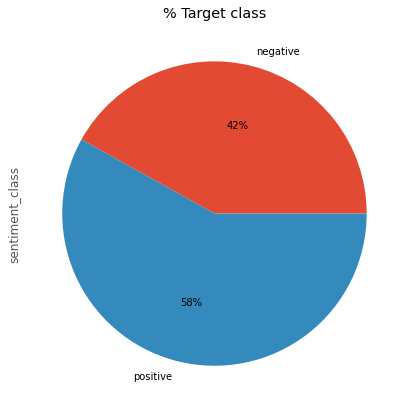

In [ ]:
((train_txt.groupby('sentiment_class')['sentiment_class'].count()/train_txt.shape[0])*100).plot(kind='pie',figsize=(7,7),title='% Target class', autopct='%1.0f%%')

In [ ]:
train_txt['PhraseLength']=train_txt['text'].apply(lambda x: len(x.split(" ")))
train_txt.sort_values(by='PhraseLength', ascending=False).head()

,text,label,sentiment_class,PhraseLength
2191,Cuốn sách này của Tờ Pi mình không mua mà đọc ...,1,negative,483
5773,Mình đặt mua Tạm biệt em ổn hộ một người bạn. ...,1,negative,398
2804,Tôi thực sự không thích cuốn sách này. Tôi khô...,1,negative,395
6764,Mình cho cuốn sách này 1 sao vì hai lý do sau ...,1,negative,338
5153,Em yêu yêu đã ngủ chưaAnh yêu yêu cũng mới vừa...,1,negative,279


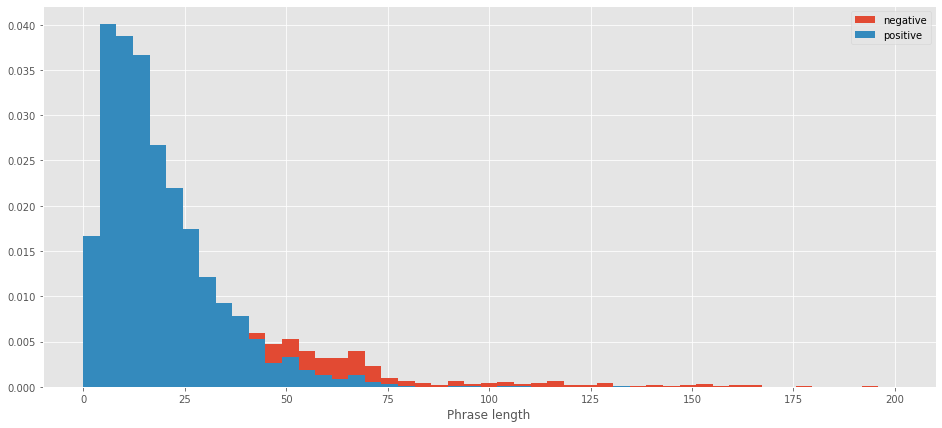

In [ ]:
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train_txt[train_txt['sentiment_class']=='negative']['PhraseLength'],bins=bins,density=True,label='negative')
#plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'],bins=bins,density=True,label='somewhat negative')
#plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'],bins=bins,density=True,label='neutral')
#plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(train_txt[train_txt['sentiment_class']=='positive']['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
open_=open("/content/drive/MyDrive/[1] Thesis/Data/vn_stopwords.txt","r")
STOPWORDS=open_.read().splitlines()
stopwords = set(STOPWORDS) 

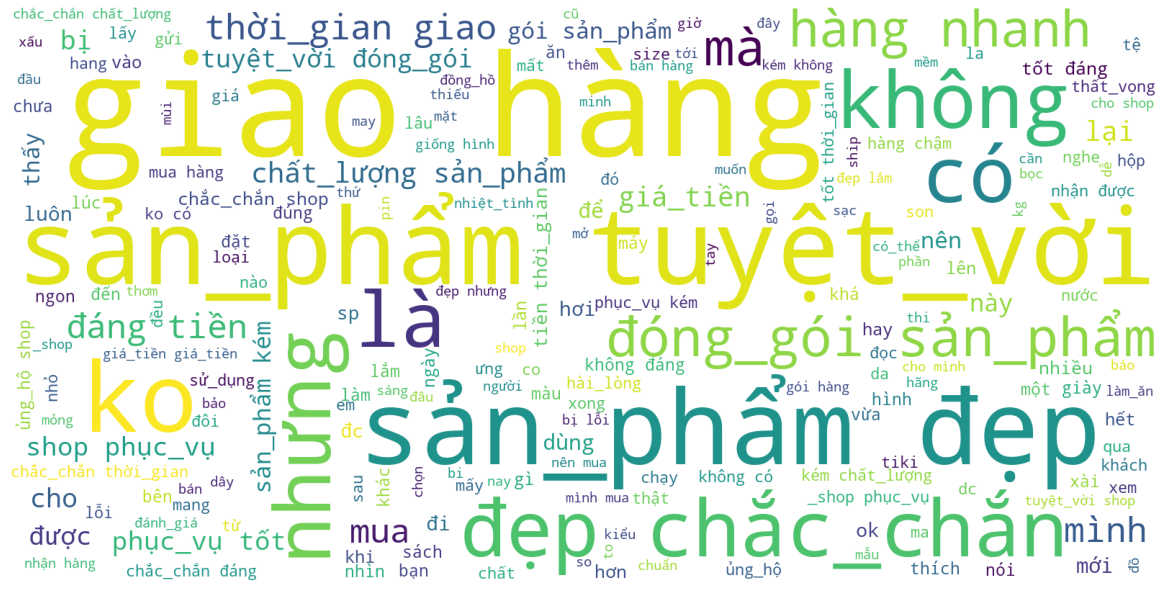

In [ ]:
word_cloud_common_words=[]  
for index, row in train_txt.iterrows(): 
    word_cloud_common_words.append((clean_doc(row['text'],True))) 
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 5).generate(''.join(word_cloud_common_words)) 
  
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### KSE

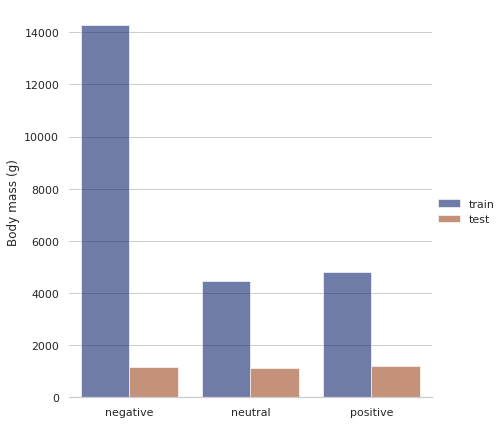

In [ ]:
train_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/kse_train.csv")
test_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/kse_test.csv")

train_txt['sentiment_class'] = train_txt['label'].map({0:'negative',1:'positive',2:'neutral'})
test_txt['sentiment_class'] = test_txt['label'].map({0:'negative',1:'positive',2:'neutral'})

num_label=3
train_=pd.DataFrame({'count' : train_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['train']*num_label}).reset_index()
test_=pd.DataFrame({'count' : test_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['test']*num_label}).reset_index()

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=train_.append(test_), kind="bar",
    x="sentiment_class", y="count", hue="hue_",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")


### UIT_VSFC

In [ ]:
train_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/uit_vsfc_train.csv")
test_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/uit_vsfc_test.csv")
dev_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/uit_vsfc_dev.csv")

train_txt['sentiment_class'] = train_txt['label'].map({0:'negative',1:'neutral',2:'positive'})
test_txt['sentiment_class'] = test_txt['label'].map({0:'negative',1:'neutral',2:'positive'})
dev_txt['sentiment_class'] = dev_txt['label'].map({0:'negative',1:'neutral',2:'positive'})

num_label=3
train_=pd.DataFrame({'count' : train_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['train']*num_label}).reset_index()
test_=pd.DataFrame({'count' : test_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['test']*num_label}).reset_index()
dev_=pd.DataFrame({'count' : dev_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['dev']*num_label}).reset_index()

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=train_.append(test_.append(dev_)), kind="bar",
    x="sentiment_class", y="count", hue="hue_",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")


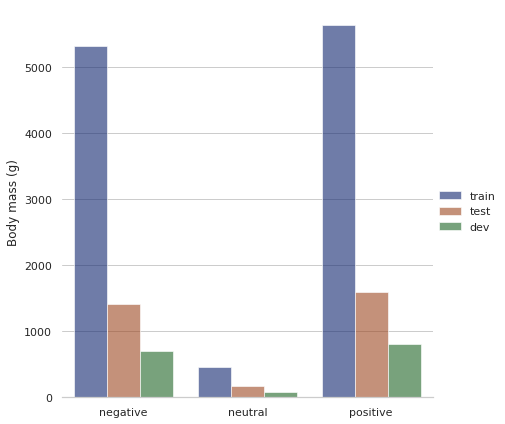

### Hotel

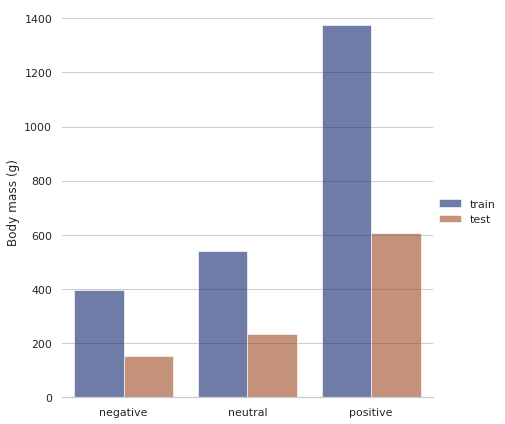

In [ ]:
train_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/hotel_train.csv")
test_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/hotel_test.csv")

train_txt['sentiment_class'] = train_txt['sentiment'].map({0:'negative',1:'positive',-1:'neutral'})
test_txt['sentiment_class'] = test_txt['sentiment'].map({0:'negative',1:'positive',-1:'neutral'})

num_label=3
train_=pd.DataFrame({'count' : train_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['train']*num_label}).reset_index()
test_=pd.DataFrame({'count' : test_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['test']*num_label}).reset_index()

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=train_.append(test_), kind="bar",
    x="sentiment_class", y="count", hue="hue_",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")


### VLSP

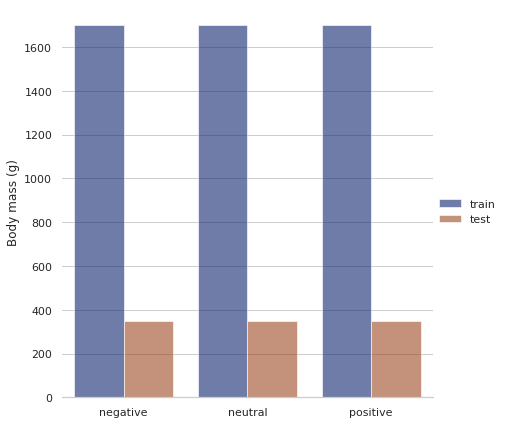

In [ ]:
train_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/vlsp_train.csv")
test_txt=pd.read_csv("/content/drive/MyDrive/[1] Thesis/Data/vlsp_test.csv")

train_txt['sentiment_class'] = train_txt['sentiment'].map({0:'negative',1:'positive',-1:'neutral'})
test_txt['sentiment_class'] = test_txt['sentiment'].map({0:'negative',1:'positive',-1:'neutral'})

num_label=3
train_=pd.DataFrame({'count' : train_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['train']*num_label}).reset_index()
test_=pd.DataFrame({'count' : test_txt.groupby( [ "sentiment_class"] ).size(),'hue_':['test']*num_label}).reset_index()

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=train_.append(test_), kind="bar",
    x="sentiment_class", y="count", hue="hue_",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")
